In [22]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [23]:
# аналог sklearn.ensemble.VotingClassifier
class MajorityVoteClassifier(BaseEstimator,ClassifierMixin):
    """ A majority vote ensemble classifier
    
    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
        Different classifiers for the ensemble
    
    vote : str, {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel' the prediction is based on
        the argmax of class labels. Else if
        'probability', the argmax of the sum of
        probabilities is used to predict the class label
        (recommended for calibrated classifiers).
    
    weights : array-like, shape = [n_classifiers]
        Optional, default: None
        If a list of `int` or `float` values are
        provided, the classifiers are weighted by
        importance; Uses uniform weights if `weights=None`.
    """
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """ Fit classifiers.
        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.
        y : array-like, shape = [n_samples]
            Vector of target class labels.
            
        Returns
        -------
        self : object
        """
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []

        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """ Predict class labels for X.
        Parameters
        ----------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.
            
        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: 
            # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                                           axis=1, arr=predictions)
            
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """ Predict class probabilities for X.
        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Training vectors, where n_samples is
            the number of samples and
            
        n_features is the number of features.
        
        Returns
        ----------
        avg_proba : array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.
        """
        
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_]) 
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [24]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy',random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.97 (+/- 0.10) [Logistic Regression]
ROC AUC: 0.93 (+/- 0.11) [Decision Tree]
ROC AUC: 0.93 (+/- 0.15) [KNN]


In [27]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.97 (+/- 0.10) [Logistic Regression]
Accuracy: 0.93 (+/- 0.11) [Decision Tree]
Accuracy: 0.93 (+/- 0.15) [KNN]
Accuracy: 0.98 (+/- 0.05) [Majority Voting]


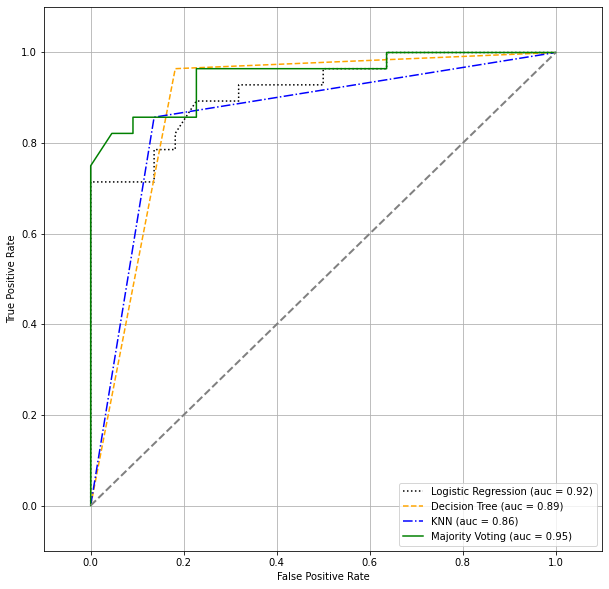

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
plt.figure(figsize=(10, 10))
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Text(-10.5, 4.5, 'Petal length [standardized]')

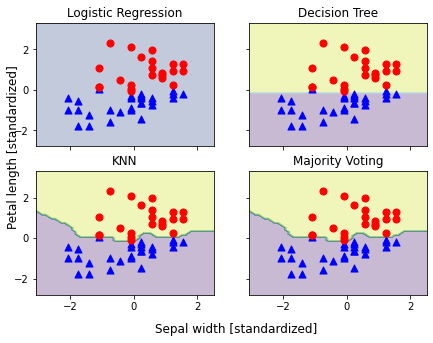

In [29]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], c='red', marker='o', s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)

In [30]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=0)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=0)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=0),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [31]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                   'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)